In [2]:
# !pip install pysisso

In [3]:
from pymatgen.core import Structure
from pymatgen.core.trajectory import Trajectory
from pymatgen.io.vasp.outputs import Xdatcar,Vasprun
# from pymatgen_diffusion.neb.pathfinder import IDPPSolver
# from pymatgen_diffusion.aimd.pathway import ProbabilityDensityAnalysis
# from pymatgen_diffusion.aimd.van_hove import VanHoveAnalysis
from pymatgen.analysis.transition_state import NEBAnalysis, combine_neb_plots
from matplotlib import pyplot as plt
from pymatgen.analysis.diffusion_analyzer import DiffusionAnalyzer,get_arrhenius_plot
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import optimize
import re
import seaborn as sns
import pandas as pd
import copy
import matplotlib.image as mpimg # mpimg 用于读取图片
from matplotlib.figure import Figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
import matplotlib as mpl
from matplotlib.pyplot import MultipleLocator
import matplotlib


/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/pymatgen/analysis/diffusion_analyzer.py:49: FutureWarning: All code in pymatgen.analysis.diffusion_analyzer has been moved to the separate add-on packagepymatgen-diffusion, which also includes a lot more functionality for analyzing diffusioncalculations. This module here is retained for backwards compatibility. It will be removed from2022.1.1.
  FutureWarning,


In [4]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [5]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

config = {
    "font.family":'serif',
    "font.size": 20,
    "mathtext.fontset":'stix',
    "font.serif": ['Times New Roman'],
    "font.weight":'bold'
}
rcParams.update(config)
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 30}
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [44]:
elements = 'S'
tet_index ={'Cl':1,'Br':1,'I':1,'S':2,'O':2}
oct_index ={'Cl':2,'Br':2,'I':2,'S':1,'O':1}
volume_dict = {'S':46.81,'Cl':30.81,'O':25.28,'Br':41.89,'I':54.687}
xmin = {'S':20,'O':10,'Cl':10}
xmax = {'S':80,'O':40,'Cl':70}
volume_1 = {'O':[10,20,30,40],'S':[20,30,40,50,60,70]}
marker_1 = {'Oct':'o','Tet':'v'}
anion_charge = {'Cl':[0.25,0.85],'Br':[0.25,0.85],'I':[0.25,0.85],'S':[0.5,1.7],'O':[0,1.7]}
anion_charge_list = {'Cl':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'I':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7]}
volume_list = [0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7]
distortion_lists2 =[3.710959e-29
,1.807483e-01
,7.160662e-01
,1.585847e+00
,2.758709e+00
,4.194799e+00]
distortion_lists1 = [1,1.04,1.08,1.12,1.16,1.2]
volume_per_list = [round(i*volume_dict[elements],2) for i in volume_list]
ss_c = [-i for i in anion_charge_list[elements]] 
ss_v = volume_list
step = 3

In [169]:
results = pd.read_csv(f'./2022-07-11-fcc/fcc_Li{elements}_do_pt.csv',header=None)
total_lens = results.shape[0]/step
results1 = pd.read_csv(f'./2022-07-11-fcc/fcc_Li{elements}_po_dt.csv',header=None)
total_lens1 = results1.shape[0]/step
results_sf = pd.read_csv(f'./2022-07-11-fcc/fcc_Li{elements}_s_f2.csv',header=None)

In [170]:
total_lens_sf = results_sf.shape[0]/2
sf_rlist = []
for i in range(0,int(total_lens_sf)):
#     print(i)
    t = results_sf.loc[i*2:i*2+1]
    t.columns = t.iloc[0]
    t = t.reset_index()
    t = t.drop(t.index[0])
    t['re_E'] = pd.to_numeric( t['re_E'])
    t['Energy'] = pd.to_numeric( t['Energy'])
    t['Force'] = pd.to_numeric( t['Force'])
#     print(t)
    sf_rlist.append(t)
data_sf_list = []
for j in sf_rlist:
    data = {}
    title = j.columns[1].split('-')
    data['d'] = float(title[2])
    data['c'] = float(title[4])
    data['v'] = float(title[6])
    data['Eframe'] = j['Energy'][1]
    data_sf_list.append(data)
r_sf = pd.DataFrame(data_sf_list)

In [171]:
rlist = []
for i in range(0,int(total_lens)):
#     print(i)
    t = results.loc[i*step:i*step+step-1]
#     print(t)
    t.columns = t.iloc[0]
    t = t.reset_index()
    t = t.drop(t.index[0])
    t['re_E'] = pd.to_numeric( t['re_E'])
    t['Energy'] = pd.to_numeric( t['Energy'])
    t['Force'] = pd.to_numeric( t['Force'])
#     print(t)
    rlist.append(t)
rlist1 = []
for i in range(0,int(total_lens1)):
#     print(i)
    t = results1.loc[i*step:i*step+step-1]
    t.columns = t.iloc[0]
    t = t.reset_index()
    t = t.drop(t.index[0])
    t['re_E'] = pd.to_numeric( t['re_E'])
    t['Energy'] = pd.to_numeric( t['Energy'])
    t['Force'] = pd.to_numeric( t['Force'])
#     print(t)
    rlist1.append(t)
data_list = []
for j in rlist:
    data = {}
    title = j.columns[1].split('-')
    data['d'] = float(title[2])
    data['c'] = float(title[4])
    data['v'] = float(title[6])
    data['Etet-Eoct'] = float(j['re_E'][tet_index[elements]])-float(j['re_E'][oct_index[elements]])
    data['Ea'] = j['re_E'].max()-j['re_E'].min()
    data['Etet'] = j['Energy'][tet_index[elements]]
    data['Eoct'] = j['Energy'][oct_index[elements]]
    data_list.append(data)
data2_list = []
for j in rlist1:
    data = {}
    title = j.columns[1].split('-')
    data['d'] = float(title[2])
    data['c'] = float(title[4])
    data['v'] = float(title[6])
    data['Etet-Eoct'] = float(j['re_E'][tet_index[elements]])-float(j['re_E'][oct_index[elements]])
    data['Ea'] = j['re_E'].max()-j['re_E'].min()
    data['Etet'] = j['Energy'][tet_index[elements]]
    data['Eoct'] = j['Energy'][oct_index[elements]]
    data2_list.append(data)
r1 = pd.DataFrame(data_list)
r2 = pd.DataFrame(data2_list)

In [71]:
step = 4
results5 = pd.read_csv(f'./2022-07-11-fcc/fcc_Li{elements}_Ea.csv',header=None)
total_lens5 = results5.shape[0]/step
rlist5 = []
for i in range(0,int(total_lens5)):
    # print(i)
    t = results5.loc[i*step:i*step+step-1]
    t.columns = t.iloc[0]
    t = t.reset_index()
    t = t.drop(t.index[0])
    t['re_E'] = pd.to_numeric( t['re_E'])
    t['Energy'] = pd.to_numeric( t['Energy'])
    t['Force'] = pd.to_numeric( t['Force'])
#     print(t)
    rlist5.append(t)
data_list5 = []
for j in rlist5:
    data = {}
    title = j.columns[1].split('-')
    # print(j['re_E'].values[0])
    data['Ea'] = j['re_E'].max()-j['re_E'].min()
    # data['Etet-Eoct'] = float(j['re_E'].values[0])-float(j['re_E'].values[-1])
    data['d'] = 100-distortion_lists2[distortion_lists1.index(float(title[2]))]
    data['c'] = float(title[4])
    data['v'] = float(title[6])*volume_dict[elements]
    # data['Etet-Eoct'] = float(j['re_E'].values[0])-float(j['re_E'].values[-1])
    
    # data['Etri'] = j['Energy'].values[1]
    # data['Etet'] = j['Energy'].values[0]
    # data['Eoct'] = j['Energy'].values[-1]
    data_list5.append(data)
r5 = pd.DataFrame(data_list5)

In [72]:
r5.to_csv('./2022-07-11-fcc/fcc_LiS_sisso_train_Ea1.csv',sep='\t')

# E_Oct_i

In [173]:
ss1 = [1,1.12,1.16,1.2]
ss2 =[3.710959e-29
# ,1.807483e-01
# ,7.160662e-01
,1.585847e+00
,2.758709e+00
,4.194799e+00]
ss3 = [2.651429e-12
,   1.292910e-01
,   5.143897e-01
,   1.147123e+00
,   2.014352e+00
,   3.098644e+00]
ss2 = [round(i,2) for i in ss2]
ss3 = [round(i,2) for i in ss3]
ss4 = volume_list
ss4_1 = [round(k*volume_dict[elements],2) for k in volume_list]
marker_list = ['a','b','c','d','e','f','g'] 
ress_lists_oct = []
v_list_3 = []
c_list_3 = []
d_list_3 = []
index_2 = 1
for index_1 in range(0,len(ss1)):
    ress_list1 = []
    v_list_2 = []
    c_list_2 = []
    d_list_2 = []
    for k in ss1[index_1:index_1+1]:
        for i in ss_c:
            data_l = []
            v_list_1 = []
            c_list_1 = []
            d_list_1 = []
            for j in ss_v:
        #         print(i)
                
#         r1[(r1['c']==-i)&(r1['v']==j)&(r1['d']==k)].values[0][5]+
                E_oct_i0 = (r5[(r5['c']==-i)&(r5['v']==j)&(r5['d']==1)].values[0][-2]-r_sf[(r_sf['c']==-i)&(r_sf['v']==j)&(r_sf['d']==1)].values[0][-1])+1.906
                E_oct_i = r5[(r5['c']==-i)&(r5['v']==j)&(r5['d']==k)].values[0][-2]-r_sf[(r_sf['c']==-i)&(r_sf['v']==j)&(r_sf['d']==k)].values[0][-1]+1.906 #- E_oct_i0
#                 E_tet_i = r2[(r2['c']==-i)&(r2['v']==j)&(r2['d']==k)].values[0][6]-r_sf[(r_sf['c']==-i)&(r_sf['v']==j)&(r_sf['d']==k)].values[0][-1] - (r2[(r2['c']==-i)&(r2['v']==j)&(r2['d']==1)].values[0][6]-r_sf[(r_sf['c']==-i)&(r_sf['v']==j)&(r_sf['d']==1)].values[0][-1])
                if E_oct_i>30:
                    print(str(k)+' '+str(i)+' '+str(j)+" "+str(E_oct_i))
                data_l.append(E_oct_i)
                v_list_1.append(round(j*volume_dict[elements],2))
                c_list_1.append(i)
                d_list_1.append(ss2[ss1.index(k)])
            ress_list1.append(data_l)
            v_list_2.append(v_list_1)
            c_list_2.append(c_list_1)
            d_list_2.append(d_list_1)
    ress_lists_oct.append(ress_list1)
    v_list_3.append(v_list_2)
    c_list_3.append(c_list_2)
    d_list_3.append(d_list_2)
# ress_list2 = []
# for k in ss1[0:1]:
#     for i in ss_c:
#         data_l = []
#         for j in ss_v:
#     #         print(i)
#             data_l.append(r2[(r2['c']==i)&(r2['v']==j)&(r2['d']==k)].values[0][3])
#         ress_list2.append(data_l)

# Ea_list = []
# for k in ss1[0:1]:
#     for i in ss_c:
#         data_l = []
#         for j in ss_v:
#             data_l.append(r1[(r1['c']==i)&(r1['v']==j)&(r1['d']==k)].values[0][4])
#         Ea_list.append(data_l)
# Etet_list = []
# for k in ss1[0:1]:
#     for i in ss_c:
#         data_l = []
#         for j in ss_v:
#             data_l.append(r1[(r1['c']==i)&(r1['v']==j)&(r1['d']==k)].values[0][5])
#         Etet_list.append(data_l)
# Eoct_list = []
# for k in ss1[0:1]:
#     for i in ss_c:
#         data_l = []
#         for j in ss_v:
#             data_l.append(r2[(r2['c']==i)&(r2['v']==j)&(r2['d']==k)].values[0][6])
#         Eoct_list.append(data_l)
# df_tet_oct_list = []
# # print(ress_lists[2])
# for i in ress_lists_oct:
#     # print(i)
#     df_tet_oct = pd.DataFrame(i,columns=ss2,index=ss4_1)
# #     df_tet_oct_norm = df_tet_oct.sub(df_tet_oct[ss1[0]], axis=0)
#     df_tet_oct_list.append(df_tet_oct)

In [174]:
# ress_lists_oct[0][5]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.


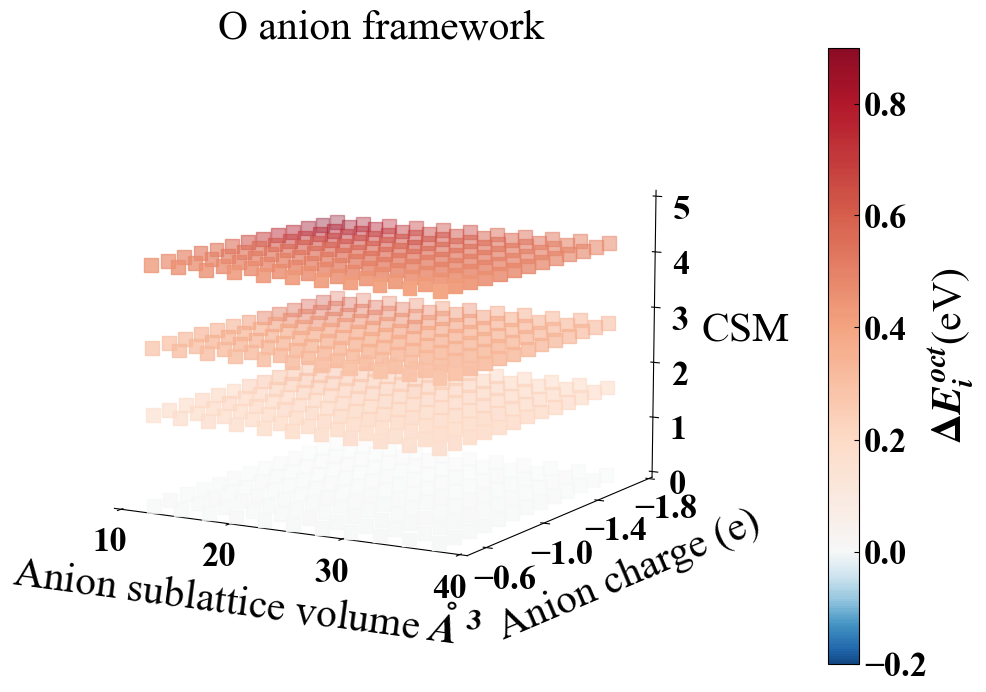

In [186]:
v_lim = {'Cl':[20,40],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[20,75],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[20,60],
          'I':[30,60],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[10,40]}

E_max = {'Cl':1.0,
#                  0.65,0.7,0.75,0.8,0.85],
           'S':2.0,
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':1.0,
          'I':1.0,
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':2.0}
anion_charge_list = {'Cl':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'I':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7]}
charge_coefficient_list1 = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7]

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
size1 = 30
size2 = 20
l_v = [round(k*volume_dict[elements],2) for k in volume_list]  
l_c = anion_charge_list[elements]
fig = plt.figure(figsize=(15,8))
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
# print(X)
# d = distortion_ratio_list
# ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
v = np.array(v_list_3)
c = np.array(c_list_3)
colors = np.array(ress_lists_oct)
d = np.array(d_list_3)
# print(v)
np.max(colors)
cm = plt.cm.get_cmap('RdBu_r')
cm1 = shiftedColorMap(cm,start=0.05,midpoint=2/11,stop=0.95)
# print(cm1)
a = ax.scatter(v,c,d,c=colors,cmap=cm1,s=100,marker='s',vmin=-0.2,vmax=0.9)
# for i in d[0:-2]:
#     cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)],levels=100, zdir='z', offset=i, cmap='RdBu_r')
# cset = ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
# cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)
# cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)], zdir='y', offset=40, cmap=cm.coolwarm)
cbar = fig.colorbar(a,ax=ax,pad=0.12,fraction=0.036)
plt.title(f'{elements} anion framework',size=size1)
# - E_{i}^{oct}
cbar.set_label('$\Delta E_{i}^{oct} $(eV)',rotation=90, labelpad=0,size=size1)
cbar.ax.tick_params(labelsize=size1/1.2)
# cbar.ax.set_label('Etet-Eoct')
ax.grid(False)
ax.view_init(elev=10,    # 仰角    # 方位角
            azim=-60)
ax.tick_params(labelsize=size1/1.2)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.patch.set_alpha(0.0)
ax.set_xlabel(f'Anion sublattice volume $\AA^3$',labelpad=size2,size=size1)
ax.set_xlim(v_lim[elements][0], v_lim[elements][-1])
ax.set_ylabel('Anion charge (e)',labelpad=size2,size=size1)
ax.set_ylim(anion_charge_list[elements][0], anion_charge_list[elements][-1])
ax.set_zlabel('CSM', labelpad=size2,size=size1)
# ax.set_yticks(fontproperties = 'Times New Roman', size = 30)
ax.set_zticks(ticks = [0,1,2,3,4,5])
ax.set_yticks(ticks = [-0.6,-1.0,-1.4,-1.8,])
ax.set_xticks(ticks = volume_1[elements])
ax.set_zlim(0,5)
plt.margins(0,0,0)
plt.savefig(f'./{elements}_oct.png',bbox_inches='tight')
plt.show()

/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.


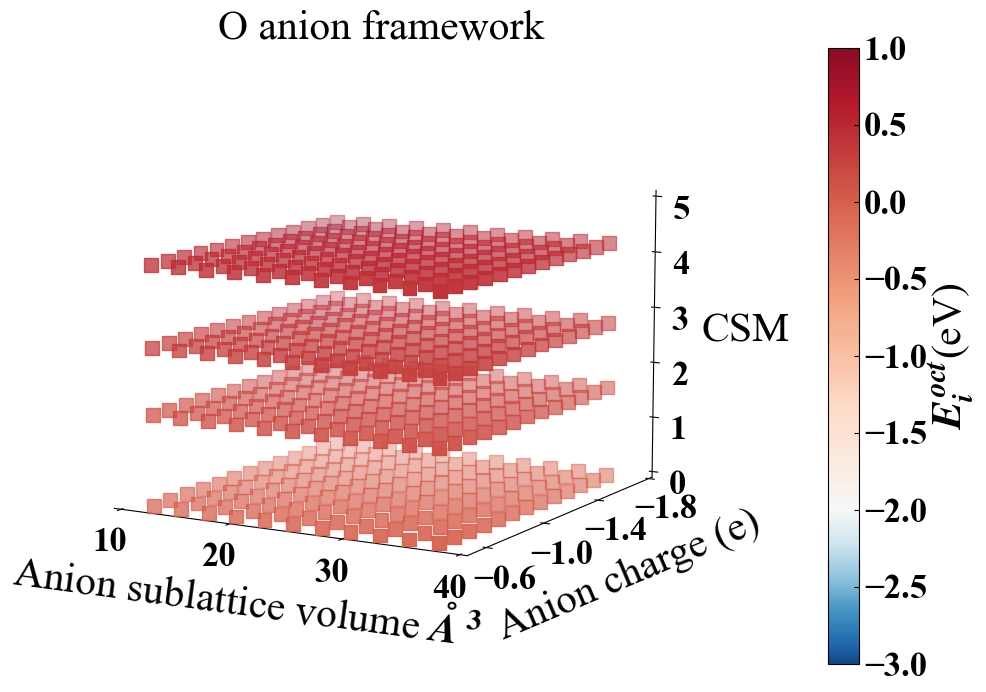

In [176]:
v_lim = {'Cl':[20,40],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[20,75],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[20,60],
          'I':[30,60],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[10,40]}

E_max = {'Cl':1.0,
#                  0.65,0.7,0.75,0.8,0.85],
           'S':2.0,
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':1.0,
          'I':1.0,
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':2.0}
anion_charge_list = {'Cl':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'I':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7]}
charge_coefficient_list1 = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7]

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
size1 = 30
size2 = 20
l_v = [round(k*volume_dict[elements],2) for k in volume_list]  
l_c = anion_charge_list[elements]
fig = plt.figure(figsize=(15,8))
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
# print(X)
# d = distortion_ratio_list
# ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
v = np.array(v_list_3)
c = np.array(c_list_3)
colors = np.array(ress_lists_oct)
d = np.array(d_list_3)
# print(v)
np.max(colors)
cm = plt.cm.get_cmap('RdBu_r')
cm1 = shiftedColorMap(cm,start=0.05,midpoint=1/4,stop=0.95)
# print(cm1)
a = ax.scatter(v,c,d,c=colors,cmap=cm1,s=100,marker='s',vmin=-3.0,vmax=1.0)
# for i in d[0:-2]:
#     cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)],levels=100, zdir='z', offset=i, cmap='RdBu_r')
# cset = ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
# cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)
# cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)], zdir='y', offset=40, cmap=cm.coolwarm)
cbar = fig.colorbar(a,ax=ax,pad=0.12,fraction=0.036)
plt.title(f'{elements} anion framework',size=size1)
# - E_{i}^{oct}
cbar.set_label('$E_{i}^{oct} $(eV)',rotation=90, labelpad=0,size=size1)
cbar.ax.tick_params(labelsize=size1/1.2)
# cbar.ax.set_label('Etet-Eoct')
ax.grid(False)
ax.view_init(elev=10,    # 仰角    # 方位角
            azim=-60)
ax.tick_params(labelsize=size1/1.2)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.patch.set_alpha(0.0)
ax.set_xlabel(f'Anion sublattice volume $\AA^3$',labelpad=size2,size=size1)
ax.set_xlim(v_lim[elements][0], v_lim[elements][-1])
ax.set_ylabel('Anion charge (e)',labelpad=size2,size=size1)
ax.set_ylim(anion_charge_list[elements][0], anion_charge_list[elements][-1])
ax.set_zlabel('CSM', labelpad=size2,size=size1)
# ax.set_yticks(fontproperties = 'Times New Roman', size = 30)
ax.set_zticks(ticks = [0,1,2,3,4,5])
ax.set_yticks(ticks = [-0.6,-1.0,-1.4,-1.8,])
ax.set_xticks(ticks = volume_1[elements])
ax.set_zlim(0,5)
plt.margins(0,0,0)
plt.savefig(f'./{elements}_oct.png',bbox_inches='tight')
plt.show()

In [188]:
ss1 = [1,1.12,1.16,1.2]
ss2 =[3.710959e-29
# ,1.807483e-01
# ,7.160662e-01
,1.585847e+00
,2.758709e+00
,4.194799e+00]
ss3 = [2.651429e-12
,   1.292910e-01
,   5.143897e-01
,   1.147123e+00
,   2.014352e+00
,   3.098644e+00]
ss2 = [round(i,2) for i in ss2]
ss3 = [round(i,2) for i in ss3]
ss4 = volume_list
ss4_1 = [round(k*volume_dict[elements],2) for k in volume_list]
marker_list = ['a','b','c','d','e','f','g'] 
ress_lists_tet = []
v_list_3 = []
c_list_3 = []
d_list_3 = []
index_2 = 1
for index_1 in range(0,len(ss1)):
    ress_list1 = []
    v_list_2 = []
    c_list_2 = []
    d_list_2 = []
    for k in ss1[index_1:index_1+1]:
        for i in ss_c:
            data_l = []
            v_list_1 = []
            c_list_1 = []
            d_list_1 = []
            for j in ss_v:
        #         print(i)
                
#         r1[(r1['c']==-i)&(r1['v']==j)&(r1['d']==k)].values[0][5]+
                Etet_i0 = (r2[(r2['c']==-i)&(r2['v']==j)&(r2['d']==1)].values[0][6]-r_sf[(r_sf['c']==-i)&(r_sf['v']==j)&(r_sf['d']==1)].values[0][-1]) +1.906
                # E_oct_i = r1[(r1['c']==-i)&(r1['v']==j)&(r1['d']==k)].values[0][5]-r_sf[(r_sf['c']==-i)&(r_sf['v']==j)&(r_sf['d']==k)].values[0][-1] - (r1[(r1['c']==-i)&(r1['v']==j)&(r1['d']==1)].values[0][5]-r_sf[(r_sf['c']==-i)&(r_sf['v']==j)&(r_sf['d']==1)].values[0][-1])
                E_tet_i = r2[(r2['c']==-i)&(r2['v']==j)&(r2['d']==k)].values[0][6]-r_sf[(r_sf['c']==-i)&(r_sf['v']==j)&(r_sf['d']==k)].values[0][-1]+1.906 #- Etet_i0
        
                data_l.append(E_tet_i)
                v_list_1.append(round(j*volume_dict[elements],2))
                c_list_1.append(i)
                d_list_1.append(ss2[ss1.index(k)])
            ress_list1.append(data_l)
            v_list_2.append(v_list_1)
            c_list_2.append(c_list_1)
            d_list_2.append(d_list_1)
    ress_lists_tet.append(ress_list1)
    v_list_3.append(v_list_2)
    c_list_3.append(c_list_2)
    d_list_3.append(d_list_2)


In [189]:
# ress_lists_tet

/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.


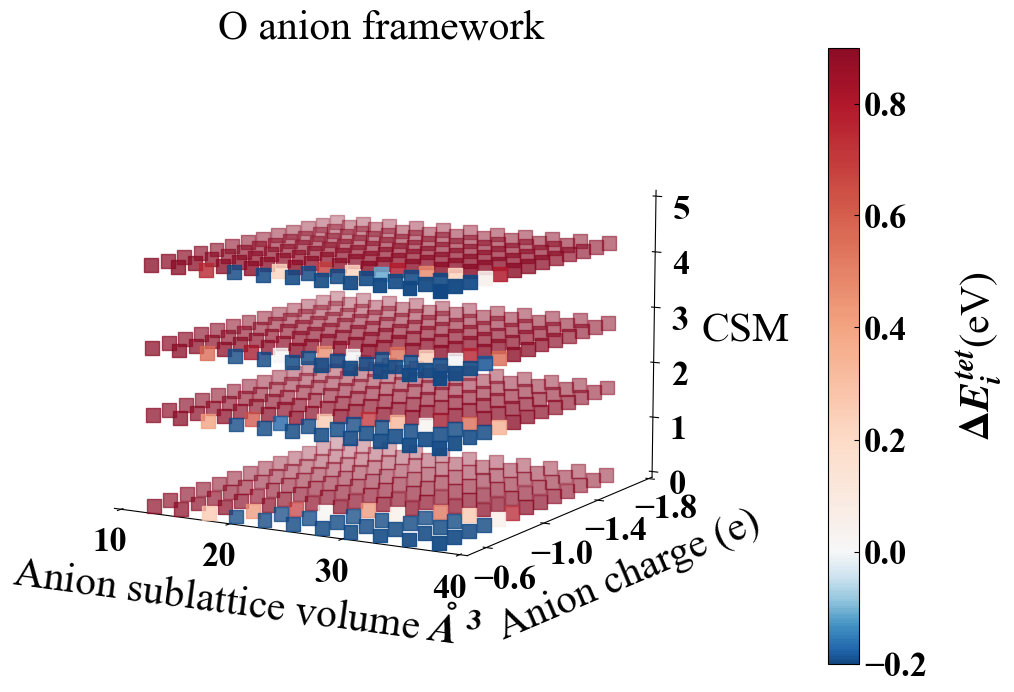

In [190]:
v_lim = {'Cl':[20,40],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[20,75],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[20,60],
          'I':[30,60],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[10,40]}

E_max = {'Cl':1.0,
#                  0.65,0.7,0.75,0.8,0.85],
           'S':2.0,
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':1.0,
          'I':1.0,
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':2.0}
anion_charge_list = {'Cl':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'I':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7]}
charge_coefficient_list1 = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7]
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
size1 = 30
size2 = 20
l_v = [round(k*volume_dict[elements],2) for k in volume_list]  
l_c = anion_charge_list[elements]
fig = plt.figure(figsize=(15,8))
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
# print(X)
# d = distortion_ratio_list
# ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
v = np.array(v_list_3)
c = np.array(c_list_3)
colors = np.array(ress_lists_tet)
d = np.array(d_list_3)
# print(v)
np.max(colors)
cm = plt.cm.get_cmap('RdBu_r')
cm1 = shiftedColorMap(cm,start=0.05,midpoint=2/11,stop=0.95)
a = ax.scatter(v,c,d,c=colors,cmap=cm1,s=100,marker='s',vmin=-0.20,vmax=0.9)
# for i in d[0:-2]:
#     cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)],levels=100, zdir='z', offset=i, cmap='RdBu_r')
# cset = ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
# cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)
# cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)], zdir='y', offset=40, cmap=cm.coolwarm)
cbar = fig.colorbar(a,ax=ax,pad=0.12,fraction=0.036)
plt.title(f'{elements} anion framework',size=size1)
# - E_{i}^{oct}
cbar.set_label('$\Delta E_{i}^{tet} $(eV)',rotation=90,labelpad=size2,size=size1)
cbar.ax.tick_params(labelsize=size1/1.2)
# cbar.ax.set_label('Etet-Eoct')
ax.grid(False)
ax.view_init(elev=10,    # 仰角    # 方位角
            azim=-60)
ax.tick_params(labelsize=size1/1.2)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.patch.set_alpha(0.0)
ax.set_xlabel(f'Anion sublattice volume $\AA^3$',labelpad=size2,size=size1)
ax.set_xlim(v_lim[elements][0], v_lim[elements][-1])
ax.set_ylabel('Anion charge (e)',labelpad=size2,size=size1)
ax.set_ylim(anion_charge_list[elements][0], anion_charge_list[elements][-1])
ax.set_zlabel('CSM', labelpad=size2,size=size1)
# ax.set_yticks(fontproperties = 'Times New Roman', size = 30)
ax.set_zticks(ticks = [0,1,2,3,4,5])
ax.set_yticks(ticks = [-0.6,-1.0,-1.4,-1.8,])
ax.set_xticks(ticks = volume_1[elements])
ax.set_zlim(0,5)
plt.margins(0,0,0)
plt.savefig(f'./{elements}_tet.png',bbox_inches='tight')
plt.show()

/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.


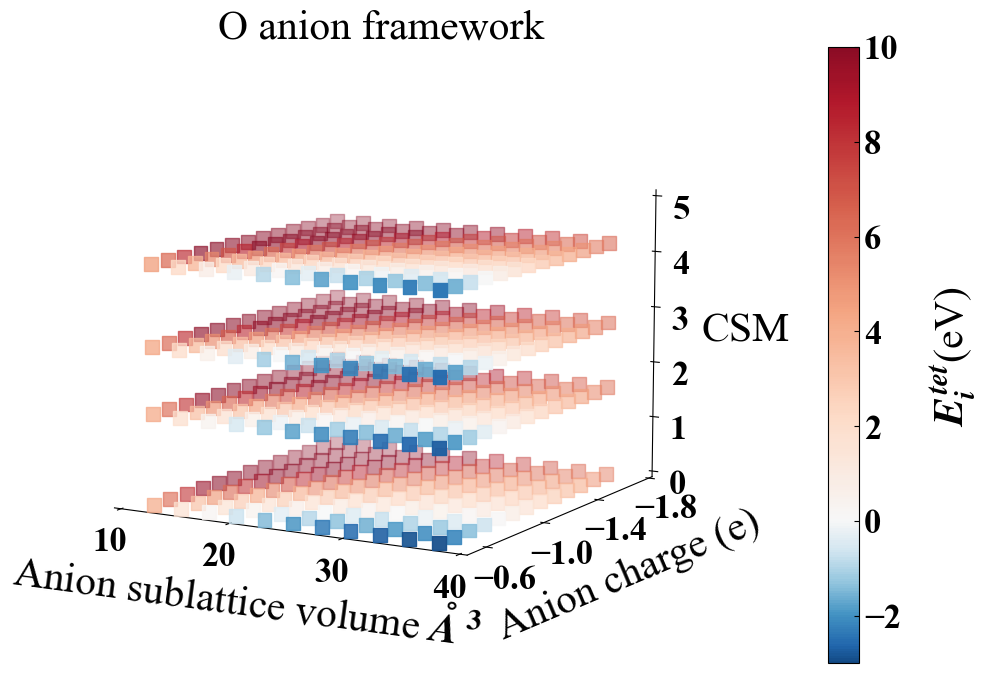

In [192]:
v_lim = {'Cl':[20,40],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[20,75],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[20,60],
          'I':[30,60],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[10,40]}

E_max = {'Cl':1.0,
#                  0.65,0.7,0.75,0.8,0.85],
           'S':2.0,
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':1.0,
          'I':1.0,
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':2.0}
anion_charge_list = {'Cl':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'I':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7]}
charge_coefficient_list1 = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7]
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
size1 = 30
size2 = 20
l_v = [round(k*volume_dict[elements],2) for k in volume_list]  
l_c = anion_charge_list[elements]
fig = plt.figure(figsize=(15,8))
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
# print(X)
# d = distortion_ratio_list
# ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
v = np.array(v_list_3)
c = np.array(c_list_3)
colors = np.array(ress_lists_tet)
d = np.array(d_list_3)
# print(v)
np.max(colors)
cm = plt.cm.get_cmap('RdBu_r')
cm1 = shiftedColorMap(cm,start=0.05,midpoint=3/13,stop=0.95)
a = ax.scatter(v,c,d,c=colors,cmap=cm1,s=100,marker='s',vmin=-3.0,vmax=10)
# for i in d[0:-2]:
#     cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)],levels=100, zdir='z', offset=i, cmap='RdBu_r')
# cset = ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
# cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)
# cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)], zdir='y', offset=40, cmap=cm.coolwarm)
cbar = fig.colorbar(a,ax=ax,pad=0.12,fraction=0.036)
plt.title(f'{elements} anion framework',size=size1)
# - E_{i}^{oct}
cbar.set_label('$E_{i}^{tet} $(eV)',rotation=90,labelpad=size2,size=size1)
cbar.ax.tick_params(labelsize=size1/1.2)
# cbar.ax.set_label('Etet-Eoct')
ax.grid(False)
ax.view_init(elev=10,    # 仰角    # 方位角
            azim=-60)
ax.tick_params(labelsize=size1/1.2)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.patch.set_alpha(0.0)
ax.set_xlabel(f'Anion sublattice volume $\AA^3$',labelpad=size2,size=size1)
ax.set_xlim(v_lim[elements][0], v_lim[elements][-1])
ax.set_ylabel('Anion charge (e)',labelpad=size2,size=size1)
ax.set_ylim(anion_charge_list[elements][0], anion_charge_list[elements][-1])
ax.set_zlabel('CSM', labelpad=size2,size=size1)
# ax.set_yticks(fontproperties = 'Times New Roman', size = 30)
ax.set_zticks(ticks = [0,1,2,3,4,5])
ax.set_yticks(ticks = [-0.6,-1.0,-1.4,-1.8,])
ax.set_xticks(ticks = volume_1[elements])
ax.set_zlim(0,5)
plt.margins(0,0,0)
plt.savefig(f'./{elements}_tet.png',bbox_inches='tight')
plt.show()

In [181]:
ss1 = [1,1.12,1.16,1.2]
ss2 =[3.710959e-29
# ,1.807483e-01
# ,7.160662e-01
,1.585847e+00
,2.758709e+00
,4.194799e+00]
ss3 = [2.651429e-12
,   1.292910e-01
,   5.143897e-01
,   1.147123e+00
,   2.014352e+00
,   3.098644e+00]
ss2 = [round(i,2) for i in ss2]
ss3 = [round(i,2) for i in ss3]
ss4 = volume_list
ss4_1 = [round(k*volume_dict[elements],2) for k in volume_list]
marker_list = ['a','b','c','d','e','f','g'] 
ress_lists_oct_tet = []
v_list_3 = []
c_list_3 = []
d_list_3 = []
index_2 = 1
for index_1 in range(0,len(ss1)):
    ress_list1_oct_tet = []
    v_list_2 = []
    c_list_2 = []
    d_list_2 = []
    for k in ss1[index_1:index_1+1]:
        for i in ss_c:
            data_l = []
            v_list_1 = []
            c_list_1 = []
            d_list_1 = []
            for j in ss_v:
        #         print(i)
                
#         r1[(r1['c']==-i)&(r1['v']==j)&(r1['d']==k)].values[0][5]+
                E_oct_i = r1[(r1['c']==-i)&(r1['v']==j)&(r1['d']==k)].values[0][5]-r_sf[(r_sf['c']==-i)&(r_sf['v']==j)&(r_sf['d']==k)].values[0][-1] 
    # - (r1[(r1['c']==-i)&(r1['v']==j)&(r1['d']==1)].values[0][5]-r_sf[(r_sf['c']==-i)&(r_sf['v']==j)&(r_sf['d']==1)].values[0][-1])
                E_tet_i = r2[(r2['c']==-i)&(r2['v']==j)&(r2['d']==k)].values[0][6]-r_sf[(r_sf['c']==-i)&(r_sf['v']==j)&(r_sf['d']==k)].values[0][-1] 
        # - (r2[(r2['c']==-i)&(r2['v']==j)&(r2['d']==1)].values[0][6]-r_sf[(r_sf['c']==-i)&(r_sf['v']==j)&(r_sf['d']==1)].values[0][-1])
                data_l.append(E_tet_i-E_oct_i)
                v_list_1.append(round(j*volume_dict[elements],2))
                c_list_1.append(i)
                d_list_1.append(ss2[ss1.index(k)])
            ress_list1_oct_tet.append(data_l)
            v_list_2.append(v_list_1)
            c_list_2.append(c_list_1)
            d_list_2.append(d_list_1)
    ress_lists_oct_tet.append(ress_list1_oct_tet)
    v_list_3.append(v_list_2)
    c_list_3.append(c_list_2)
    d_list_3.append(d_list_2)
# ress_list2 = []
# for k in ss1[0:1]:
#     for i in ss_c:
#         data_l = []
#         for j in ss_v:
#     #         print(i)
#             data_l.append(r2[(r2['c']==i)&(r2['v']==j)&(r2['d']==k)].values[0][3])
#         ress_list2.append(data_l)

# Ea_list = []
# for k in ss1[0:1]:
#     for i in ss_c:
#         data_l = []
#         for j in ss_v:
#             data_l.append(r1[(r1['c']==i)&(r1['v']==j)&(r1['d']==k)].values[0][4])
#         Ea_list.append(data_l)
# Etet_list = []
# for k in ss1[0:1]:
#     for i in ss_c:
#         data_l = []
#         for j in ss_v:
#             data_l.append(r1[(r1['c']==i)&(r1['v']==j)&(r1['d']==k)].values[0][5])
#         Etet_list.append(data_l)
# Eoct_list = []
# for k in ss1[0:1]:
#     for i in ss_c:
#         data_l = []
#         for j in ss_v:
#             data_l.append(r2[(r2['c']==i)&(r2['v']==j)&(r2['d']==k)].values[0][6])
#         Eoct_list.append(data_l)
# df_tet_oct_list = []
# # print(ress_lists[2])
# for i in ress_lists_oct_tet:
#     # print(i)
#     df_tet_oct = pd.DataFrame(i,columns=ss2,index=ss4_1)
# #     df_tet_oct_norm = df_tet_oct.sub(df_tet_oct[ss1[0]], axis=0)
#     df_tet_oct_list.append(df_tet_oct)

In [182]:
# ress_lists_oct_tet[-1]

/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.


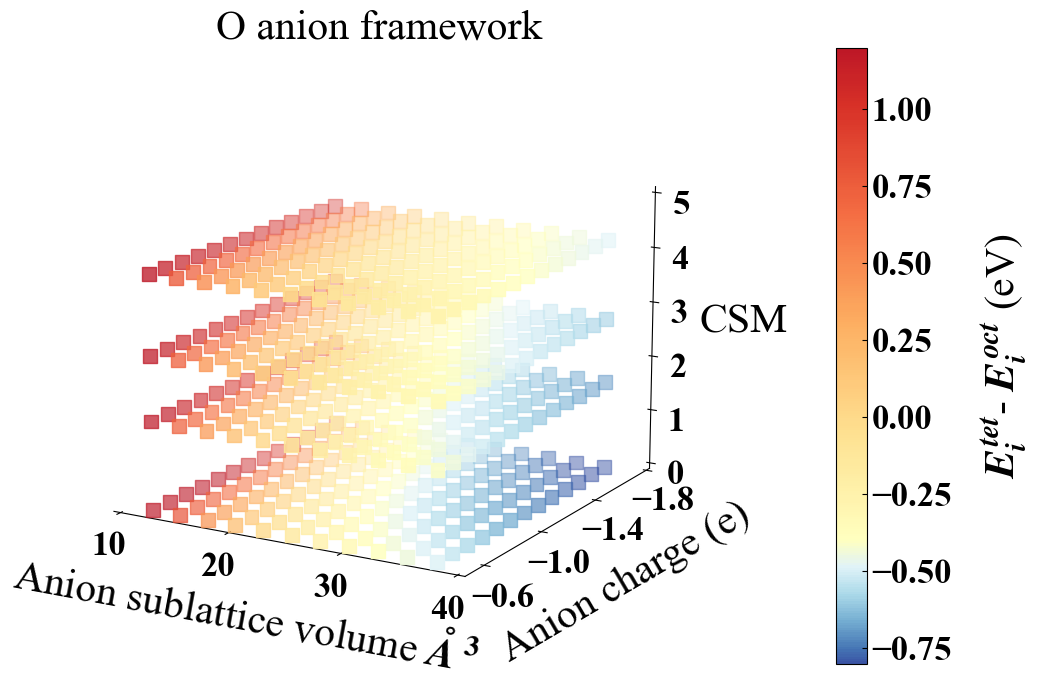

In [193]:
v_lim = {'Cl':[20,40],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[20,75],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[20,60],
          'I':[30,60],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[10,40]}

E_max = {'Cl':1.0,
#                  0.65,0.7,0.75,0.8,0.85],
           'S':2.0,
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':1.0,
          'I':1.0,
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':2.0}
anion_charge_list = {'Cl':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'I':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7]}
charge_coefficient_list1 = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7]
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
size1 = 30
size2 = 20
l_v = [round(k*volume_dict[elements],2) for k in volume_list]  
l_c = anion_charge_list[elements]
fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
# print(X)
# d = distortion_ratio_list
# ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
v = np.array(v_list_3)
c = np.array(c_list_3)
colors = np.array(ress_lists_oct_tet)
d = np.array(d_list_3)
# print(v)
np.max(colors)
cm = plt.cm.get_cmap('RdYlBu_r')
cm1 = shiftedColorMap(cm,start=0.05,midpoint=4/20,stop=0.95)
a = ax.scatter(v,c,d,c=colors,cmap=cm1,s=100,marker='s',vmin=-0.8,vmax=1.2)
# for i in d[0:-2]:
#     cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)],levels=100, zdir='z', offset=i, cmap='RdBu_r')
# cset = ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
# cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)
# cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)], zdir='y', offset=40, cmap=cm.coolwarm)
cbar = fig.colorbar(a,ax=ax,pad=0.12,fraction=0.036)
plt.title(f'{elements} anion framework',size=size1)
# - E_{i}^{oct}
cbar.set_label('$E_{i}^{tet}$- $E_{i}^{oct}$ (eV)',rotation=90,labelpad=size2,size=size1)
cbar.ax.tick_params(labelsize=size1/1.2)
# cbar.ax.set_label('Etet-Eoct')
ax.grid(False)
ax.view_init(elev=15,    # 仰角    # 方位角
            azim=-60)
ax.tick_params(labelsize=size1/1.2)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.patch.set_alpha(0.0)
ax.set_xlabel(f'Anion sublattice volume $\AA^3$',labelpad=size2,size=size1)
ax.set_xlim(v_lim[elements][0], v_lim[elements][-1])
ax.set_ylabel('Anion charge (e)',labelpad=size2,size=size1)
ax.set_ylim(anion_charge_list[elements][0], anion_charge_list[elements][-1])
ax.set_zlabel('CSM', labelpad=size2,size=size1)
# ax.set_yticks(fontproperties = 'Times New Roman', size = 30)
ax.set_zticks(ticks = [0,1,2,3,4,5])
ax.set_yticks(ticks = [-0.6,-1.0,-1.4,-1.8,])
ax.set_xticks(ticks = volume_1[elements])
ax.set_zlim(0,5)
plt.margins(0,0,0)
plt.savefig(f'./{elements}_tet_oct.png',bbox_inches='tight')
plt.show()

In [7]:
distortion_lists3 =[3.710959e-29
# ,1.807483e-01
# ,7.160662e-01
,1.585847e+00
,2.758709e+00
,4.194799e+00]
c1,v1,d1 = np.meshgrid(ss_c,volume_per_list,distortion_lists3,indexing = 'xy')

In [8]:
def fun(x1,y1,z1, const=0.1332357726E+01):
    res = 0.1100206253E+04*np.exp(-np.sqrt(z1)) -0.4861685633E+04*np.power(z1,-2)+0.6966958758E+03*np.exp(-np.array(y1))/np.power(z1,2)-0.9362902587E-05*np.power(z1,2)*np.array(x1)*np.array(y1)+0.3909158278E-01*np.log(y1)*np.sqrt(z1)+const
    return res

In [9]:
def fun1(x1,y1,z1, const=-0.73144):
    res = 0.2978339367E+03*np.power(x1,1/3)/np.power(z1,2) -0.1577326519E+00*np.power(z1,2)*np.array(y1)/np.array(x1)+ 0.2373750310E-01*np.sqrt(z1)*np.array(y1)*np.array(z1)+0.2397270685E-03*np.power(z1,2)*np.power(y1,1/3)-0.8922142537E-02*np.sqrt(x1)*np.array(y1)*np.array(z1)+const
    return res

In [10]:
def fun2(x1,y1,z1, const=-0.1442858730E+01):
    res = 0.2773945698E+03*np.exp(-np.sqrt(z1))-0.1921060395E-01*np.power(z1,2)*np.array(y1)/np.array(x1)+0.4229477838E-03*np.sqrt(y1)*np.array(x1)*np.array(z1)-0.1727387486E+00*np.log(y1)*np.sqrt(x1)/np.array(z1)+const
    return res

In [11]:
def fun3(x1,y1,z1, const=-0.3879299265E+01):
    res = 0.2124674919E+03*(np.array(x1)-np.array(y1))/np.power(z1,3)+0.1109561639E-03*np.power(z1,2)*np.sqrt(y1)+ 0.1809056336E+00*(np.array(x1)-np.array(y1))/np.power(x1,1/3)+const
    return res

/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


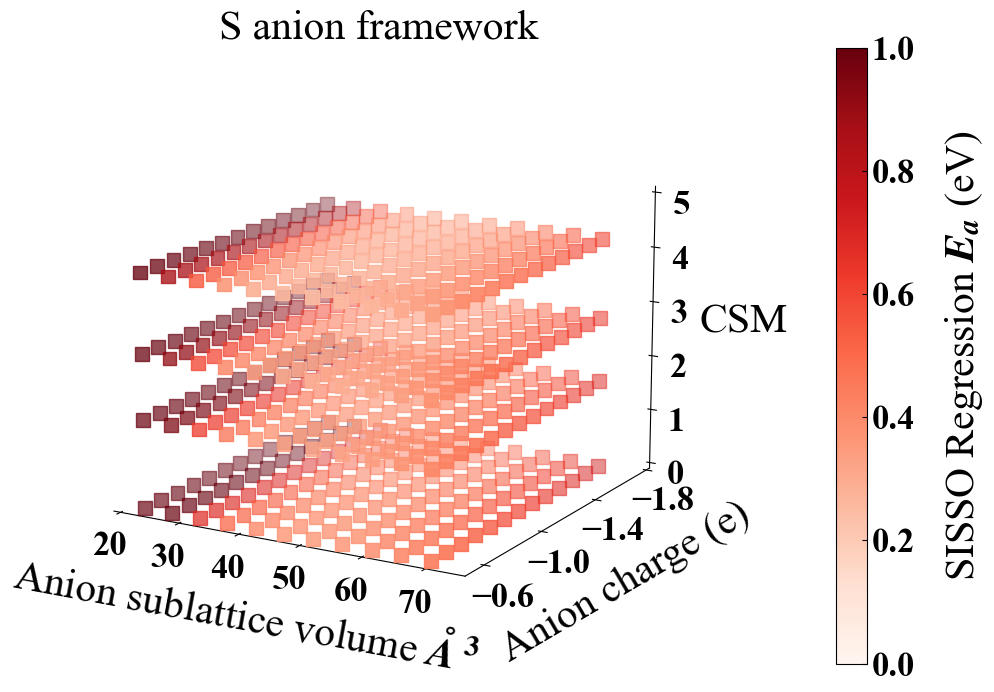

In [105]:
v_lim = {'Cl':[20,40],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[20,75],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[20,60],
          'I':[30,60],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[10,40]}

E_max = {'Cl':1.0,
#                  0.65,0.7,0.75,0.8,0.85],
           'S':2.0,
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':1.0,
          'I':1.0,
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':2.0}
anion_charge_list = {'Cl':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'I':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7]}
charge_coefficient_list1 = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7]
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
size1 = 30
size2 = 20
l_v = [round(k*volume_dict[elements],2) for k in volume_list]  
l_c = anion_charge_list[elements]
fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
# print(X)
# d = distortion_ratio_list
# ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)



c1,v1,d1 = np.meshgrid([ss_c],volume_per_list,distortion_lists3,indexing = 'ij')

colors = np.array(fun3(100-d1,-c1,v1))
# print(v)
np.max(colors)
cm = plt.cm.get_cmap('Reds')
# cm1 = shiftedColorMap(cm,start=0.05,midpoint=4/20,stop=0.95)
a = ax.scatter(v1,c1,d1,c=colors,cmap=cm,s=100,marker='s',vmin=0,vmax=1)
# for i in d[0:-2]:
#     cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)],levels=100, zdir='z', offset=i, cmap='RdBu_r')
# cset = ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
# cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)
# cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)], zdir='y', offset=40, cmap=cm.coolwarm)
cbar = fig.colorbar(a,ax=ax,pad=0.12,fraction=0.036)
plt.title(f'{elements} anion framework',size=size1)
# - E_{i}^{oct}
cbar.set_label('SISSO Regression $E_a$ (eV)',rotation=90,labelpad=size2,size=size1)
cbar.ax.tick_params(labelsize=size1/1.2)
# cbar.ax.set_label('Etet-Eoct')
ax.grid(False)
ax.view_init(elev=15,    # 仰角    # 方位角
            azim=-60)
ax.tick_params(labelsize=size1/1.2)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.patch.set_alpha(0.0)
ax.set_xlabel(f'Anion sublattice volume $\AA^3$',labelpad=size2,size=size1)
ax.set_xlim(v_lim[elements][0], v_lim[elements][-1])
ax.set_ylabel('Anion charge (e)',labelpad=size2,size=size1)
ax.set_ylim(anion_charge_list[elements][0], anion_charge_list[elements][-1])
ax.set_zlabel('CSM', labelpad=size2,size=size1)
# ax.set_yticks(fontproperties = 'Times New Roman', size = 30)
ax.set_zticks(ticks = [0,1,2,3,4,5])
ax.set_yticks(ticks = [-0.6,-1.0,-1.4,-1.8,])
ax.set_xticks(ticks = volume_1[elements])
ax.set_zlim(0,5)
plt.margins(0,0,0)
plt.savefig(f'./{elements}_a.png',bbox_inches='tight')
plt.show()

In [107]:
# c1

# benchmark

In [36]:
r5 = pd.read_csv(f'./2022-07-11-fcc/fcc_Li{elements}_predict_Ea.csv',sep='\t',header=0,index_col=0)


In [37]:
r5 = r5.round({'v': 1})

In [77]:
r5[r5['d']==distortion_lists2[-1]]

,Ea,d,c,v,Ea_tree,Ea_forest,Ea_xgboost,Ea_svm
0,0.4200,4.194799,0.8,74.9,0.4200,0.419679,0.403730,0.425631
16,0.5522,4.194799,1.1,37.4,0.5522,0.551009,0.525692,0.576403
20,0.4316,4.194799,1.5,42.1,0.4316,0.429945,0.443269,0.446440
25,1.4758,4.194799,1.4,23.4,1.4758,1.472815,1.432244,1.344753
32,0.4885,4.194799,1.4,74.9,0.4885,0.483227,0.499571,0.498142
...,...,...,...,...,...,...,...,...
968,0.4297,4.194799,1.6,42.1,0.4297,0.433131,0.432278,0.456691
975,0.4048,4.194799,1.2,42.1,0.4048,0.402246,0.413062,0.429869
976,1.0831,4.194799,0.9,28.1,1.0831,1.080402,1.104253,1.116769
991,0.3539,4.194799,0.6,70.2,0.3330,0.356712,0.334950,0.359386


In [89]:
volume_per_list = [round(i*volume_dict[elements],1) for i in volume_list][0:11]

In [90]:
distortion_lists2

[3.710959e-29, 0.1807483, 0.7160662, 1.585847, 2.758709, 4.194799]

In [108]:
ss1 = [1,1.12,1.16,1.2]
distortion_lists2 =[3.710959e-29
# ,1.807483e-01
# ,7.160662e-01
,1.585847e+00
,2.758709e+00
,4.194799e+00]
ss3 = [2.651429e-12
,   1.292910e-01
,   5.143897e-01
,   1.147123e+00
,   2.014352e+00
,   3.098644e+00]
# ss2 = [round(i,2) for i in ss2]
# ss3 = [round(i,2) for i in ss3]
ss4 = volume_list
ss4_1 = [round(k*volume_dict[elements],2) for k in volume_list]
marker_list = ['a','b','c','d','e','f','g'] 
ress_lists_Ea_tree = []
ress_lists_Ea_forest = []
ress_lists_Ea_xgboost = []
ress_lists_Ea_svm = []
err_list = []
v_list_3 = []
c_list_3 = []
d_list_3 = []
index_2 = 1
for index_1 in range(0,len(distortion_lists2)):
    ress_list1_Ea_tree = []
    ress_list1_Ea_forest = []
    ress_list1_Ea_xgboost = []
    ress_list1_Ea_svm = []
    v_list_2 = []
    c_list_2 = []
    d_list_2 = []
    
    for k in ss1[index_1:index_1+1]:
        for i in ss_c:
            data_l_tree = []
            data_l_forest = []
            data_l_xgboost = []
            data_l_svm = []
            v_list_1 = []
            c_list_1 = []
            d_list_1 = []
            for j in volume_per_list :
                # print(distortion_lists2[ss1.index(k)])
                # print(r5[(r5['c']==-i)&(r5['v']==j)&(r5['d']==ss2[-1])].values)
                d12 = distortion_lists2[ss1.index(k)]
                err1 = np.abs(r5[(r5['c']==-i)&(r5['v']==j)&(r5['d']==distortion_lists2[ss1.index(k)])].values[0][0]-fun3(100-d12,-i,j))
                E_a_tree = r5[(r5['c']==-i)&(r5['v']==j)&(r5['d']==distortion_lists2[ss1.index(k)])].values[0][-4]
                # print(E_a_tree)
                E_a_forest = r5[(r5['c']==-i)&(r5['v']==j)&(r5['d']==distortion_lists2[ss1.index(k)])].values[0][-3]
                E_a_xgboost = r5[(r5['c']==-i)&(r5['v']==j)&(r5['d']==distortion_lists2[ss1.index(k)])].values[0][-2]
                E_a_svm = r5[(r5['c']==-i)&(r5['v']==j)&(r5['d']==distortion_lists2[ss1.index(k)])].values[0][-1]
                data_l_tree.append(E_a_tree)
                data_l_forest.append(E_a_forest)
                data_l_xgboost.append(E_a_xgboost)
                data_l_svm.append(E_a_svm)
                err_list.append(err1)
                v_list_1.append(j)
                c_list_1.append(i)
                d_list_1.append(distortion_lists2[ss1.index(k)])
            ress_list1_Ea_tree.append(data_l_tree)
            ress_list1_Ea_forest.append(data_l_forest)
            ress_list1_Ea_xgboost.append(data_l_xgboost)
            ress_list1_Ea_svm.append(data_l_svm)
            # ress_list1_Ea_tree.append(data_l)
            v_list_2.append(v_list_1)
            c_list_2.append(c_list_1)
            d_list_2.append(d_list_1)
    ress_lists_Ea_tree.append(ress_list1_Ea_tree)
    ress_lists_Ea_forest.append(ress_list1_Ea_forest)
    ress_lists_Ea_xgboost.append(ress_list1_Ea_xgboost)
    ress_lists_Ea_svm.append(ress_list1_Ea_svm)
    v_list_3.append(v_list_2)
    c_list_3.append(c_list_2)
    d_list_3.append(d_list_2)
# ress_list2 = []
# for k in ss1[0:1]:
#     for i in ss_c:
#         data_l = []
#         for j in ss_v:
#     #         print(i)
#             data_l.append(r2[(r2['c']==i)&(r2['v']==j)&(r2['d']==k)].values[0][3])
#         ress_list2.append(data_l)

# Ea_list = []
# for k in ss1[0:1]:
#     for i in ss_c:
#         data_l = []
#         for j in ss_v:
#             data_l.append(r1[(r1['c']==i)&(r1['v']==j)&(r1['d']==k)].values[0][4])
#         Ea_list.append(data_l)
# Etet_list = []
# for k in ss1[0:1]:
#     for i in ss_c:
#         data_l = []
#         for j in ss_v:
#             data_l.append(r1[(r1['c']==i)&(r1['v']==j)&(r1['d']==k)].values[0][5])
#         Etet_list.append(data_l)
# Eoct_list = []
# for k in ss1[0:1]:
#     for i in ss_c:
#         data_l = []
#         for j in ss_v:
#             data_l.append(r2[(r2['c']==i)&(r2['v']==j)&(r2['d']==k)].values[0][6])
#         Eoct_list.append(data_l)
# df_tet_oct_list = []
# # print(ress_lists[2])
# for i in ress_lists_oct_tet:
#     # print(i)
#     df_tet_oct = pd.DataFrame(i,columns=ss2,index=ss4_1)
# #     df_tet_oct_norm = df_tet_oct.sub(df_tet_oct[ss1[0]], axis=0)
#     df_tet_oct_list.append(df_tet_oct)

# SVM prediction

In [110]:
np.mean(err_list)

0.07030350280148925

/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


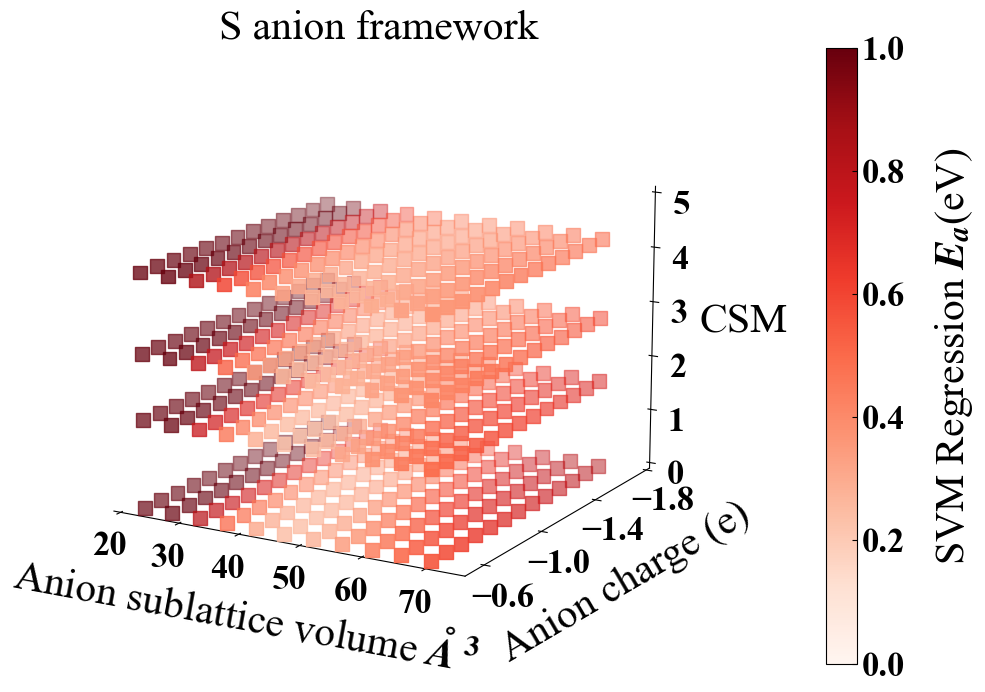

In [99]:
v_lim = {'Cl':[20,40],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[20,75],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[20,60],
          'I':[30,60],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[10,40]}

E_max = {'Cl':1.0,
#                  0.65,0.7,0.75,0.8,0.85],
           'S':2.0,
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':1.0,
          'I':1.0,
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':2.0}
anion_charge_list = {'Cl':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'I':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7]}
charge_coefficient_list1 = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7]
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
size1 = 30
size2 = 20
l_v = [round(k*volume_dict[elements],2) for k in volume_list]  
l_c = anion_charge_list[elements]
fig = plt.figure(figsize=(15,8))
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
# print(X)
# d = distortion_ratio_list
# ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
v = np.array(v_list_3)
c = np.array(c_list_3)
colors = np.array(ress_lists_Ea_svm)
d = np.array(d_list_3)
# print(v)
# np.max(colors)
# cm = plt.cm.get_cmap('RdBu_r')
cm = plt.cm.get_cmap('Reds')
a = ax.scatter(v,c,d,c=colors,cmap=cm,s=100,marker='s',vmin=0,vmax=1.0)
# for i in d[0:-2]:
#     cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)],levels=100, zdir='z', offset=i, cmap='RdBu_r')
# cset = ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
# cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)
# cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)], zdir='y', offset=40, cmap=cm.coolwarm)
cbar = fig.colorbar(a,ax=ax,pad=0.12,fraction=0.036)
plt.title(f'{elements} anion framework',size=size1)
# - E_{i}^{oct}
cbar.set_label('SVM Regression $E_a$(eV)',rotation=90,labelpad=size2,size=size1)
cbar.ax.tick_params(labelsize=size1/1.2)
ax.view_init(elev=15,    # 仰角    # 方位角
            azim=-60)
# cbar.ax.set_label('Etet-Eoct')
ax.grid(False)
ax.tick_params(labelsize=size1/1.2)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.patch.set_alpha(0.0)
ax.set_xlabel(f'Anion sublattice volume $\AA^3$',labelpad=size2,size=size1)
ax.set_xlim(v_lim[elements][0], v_lim[elements][-1])
ax.set_ylabel('Anion charge (e)',labelpad=size2,size=size1)
ax.set_ylim(anion_charge_list[elements][0], anion_charge_list[elements][-1])
ax.set_zlabel('CSM', labelpad=size2,size=size1)
# ax.set_yticks(fontproperties = 'Times New Roman', size = 30)
ax.set_zticks(ticks = [0,1,2,3,4,5])
ax.set_yticks(ticks = [-0.6,-1.0,-1.4,-1.8,])
ax.set_xticks(ticks = [20,30,40,50,60,70])
ax.set_zlim(0,5)
plt.margins(0,0,0)
plt.savefig(f'./{elements}_svm_Ea.png',bbox_inches='tight')
plt.show()

/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


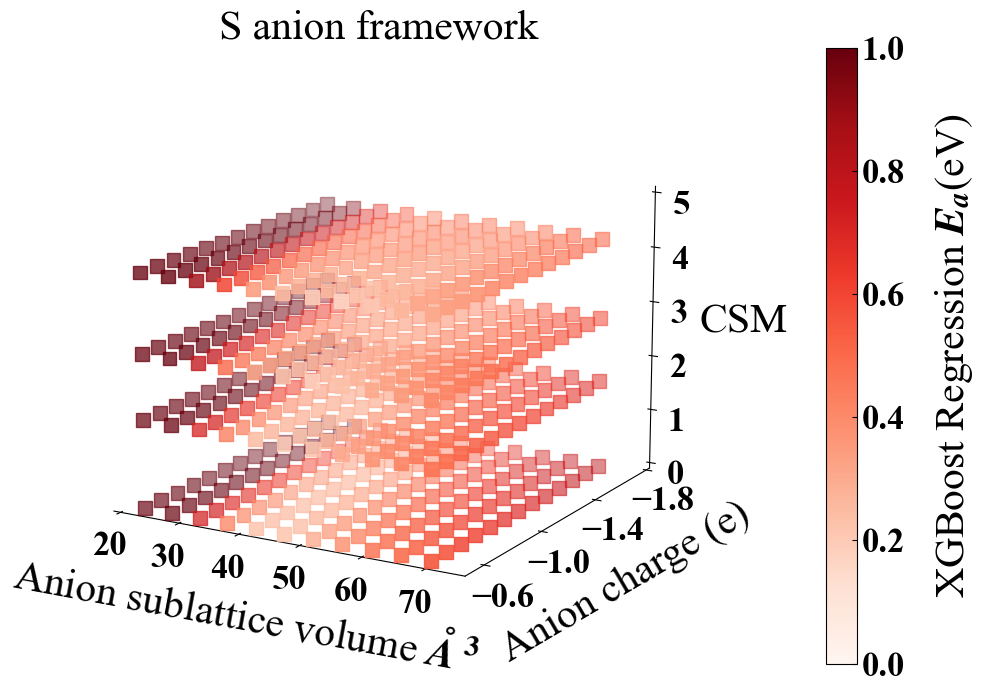

In [100]:
v_lim = {'Cl':[20,40],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[20,75],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[20,60],
          'I':[30,60],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[10,40]}

E_max = {'Cl':1.0,
#                  0.65,0.7,0.75,0.8,0.85],
           'S':2.0,
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':1.0,
          'I':1.0,
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':2.0}
anion_charge_list = {'Cl':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'I':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7]}
charge_coefficient_list1 = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7]
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
size1 = 30
size2 = 20
l_v = [round(k*volume_dict[elements],2) for k in volume_list]  
l_c = anion_charge_list[elements]
fig = plt.figure(figsize=(15,8))
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
# print(X)
# d = distortion_ratio_list
# ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
v = np.array(v_list_3)
c = np.array(c_list_3)
colors = np.array(ress_lists_Ea_xgboost)
d = np.array(d_list_3)
# print(v)
# np.max(colors)
# cm = plt.cm.get_cmap('RdBu_r')
cm = plt.cm.get_cmap('Reds')
a = ax.scatter(v,c,d,c=colors,cmap=cm,s=100,marker='s',vmin=0,vmax=1.0)
# for i in d[0:-2]:
#     cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)],levels=100, zdir='z', offset=i, cmap='RdBu_r')
# cset = ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
# cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)
# cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)], zdir='y', offset=40, cmap=cm.coolwarm)
cbar = fig.colorbar(a,ax=ax,pad=0.12,fraction=0.036)
plt.title(f'{elements} anion framework',size=size1)
# - E_{i}^{oct}
cbar.set_label('XGBoost Regression $E_a$(eV)',rotation=90,labelpad=size2,size=size1)
cbar.ax.tick_params(labelsize=size1/1.2)
ax.view_init(elev=15,    # 仰角    # 方位角
            azim=-60)
# cbar.ax.set_label('Etet-Eoct')
ax.grid(False)
ax.tick_params(labelsize=size1/1.2)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.patch.set_alpha(0.0)
ax.set_xlabel(f'Anion sublattice volume $\AA^3$',labelpad=size2,size=size1)
ax.set_xlim(v_lim[elements][0], v_lim[elements][-1])
ax.set_ylabel('Anion charge (e)',labelpad=size2,size=size1)
ax.set_ylim(anion_charge_list[elements][0], anion_charge_list[elements][-1])
ax.set_zlabel('CSM', labelpad=size2,size=size1)
# ax.set_yticks(fontproperties = 'Times New Roman', size = 30)
ax.set_zticks(ticks = [0,1,2,3,4,5])
ax.set_yticks(ticks = [-0.6,-1.0,-1.4,-1.8,])
ax.set_xticks(ticks = [20,30,40,50,60,70])
ax.set_zlim(0,5)
plt.margins(0,0,0)
plt.savefig(f'./{elements}_xgboost_Ea.png',bbox_inches='tight')
plt.show()

/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


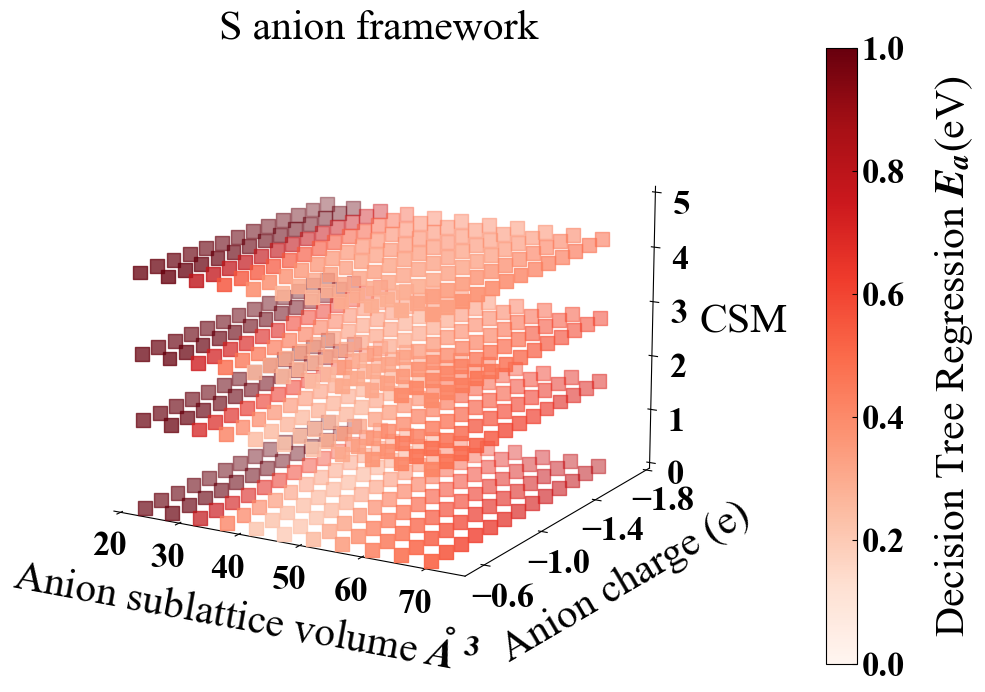

In [103]:
v_lim = {'Cl':[20,40],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[20,75],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[20,60],
          'I':[30,60],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[10,40]}

E_max = {'Cl':1.0,
#                  0.65,0.7,0.75,0.8,0.85],
           'S':2.0,
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':1.0,
          'I':1.0,
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':2.0}
anion_charge_list = {'Cl':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'I':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7]}
charge_coefficient_list1 = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7]
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
size1 = 30
size2 = 20
l_v = [round(k*volume_dict[elements],2) for k in volume_list]  
l_c = anion_charge_list[elements]
fig = plt.figure(figsize=(15,8))
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
# print(X)
# d = distortion_ratio_list
# ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
v = np.array(v_list_3)
c = np.array(c_list_3)
colors = np.array(ress_lists_Ea_tree)
d = np.array(d_list_3)
# print(v)
# np.max(colors)
# cm = plt.cm.get_cmap('RdBu_r')
cm = plt.cm.get_cmap('Reds')
a = ax.scatter(v,c,d,c=colors,cmap=cm,s=100,marker='s',vmin=0,vmax=1.0)
# for i in d[0:-2]:
#     cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)],levels=100, zdir='z', offset=i, cmap='RdBu_r')
# cset = ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
# cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)
# cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)], zdir='y', offset=40, cmap=cm.coolwarm)
cbar = fig.colorbar(a,ax=ax,pad=0.12,fraction=0.036)
plt.title(f'{elements} anion framework',size=size1)
# - E_{i}^{oct}
cbar.set_label('Decision Tree Regression $E_a$(eV)',rotation=90,labelpad=size2,size=size1)
cbar.ax.tick_params(labelsize=size1/1.2)
ax.view_init(elev=15,    # 仰角    # 方位角
            azim=-60)
# cbar.ax.set_label('Etet-Eoct')
ax.grid(False)
ax.tick_params(labelsize=size1/1.2)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.patch.set_alpha(0.0)
ax.set_xlabel(f'Anion sublattice volume $\AA^3$',labelpad=size2,size=size1)
ax.set_xlim(v_lim[elements][0], v_lim[elements][-1])
ax.set_ylabel('Anion charge (e)',labelpad=size2,size=size1)
ax.set_ylim(anion_charge_list[elements][0], anion_charge_list[elements][-1])
ax.set_zlabel('CSM', labelpad=size2,size=size1)
# ax.set_yticks(fontproperties = 'Times New Roman', size = 30)
ax.set_zticks(ticks = [0,1,2,3,4,5])
ax.set_yticks(ticks = [-0.6,-1.0,-1.4,-1.8,])
ax.set_xticks(ticks = [20,30,40,50,60,70])
ax.set_zlim(0,5)
plt.margins(0,0,0)
plt.savefig(f'./{elements}_tree_Ea.png',bbox_inches='tight')
plt.show()

/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


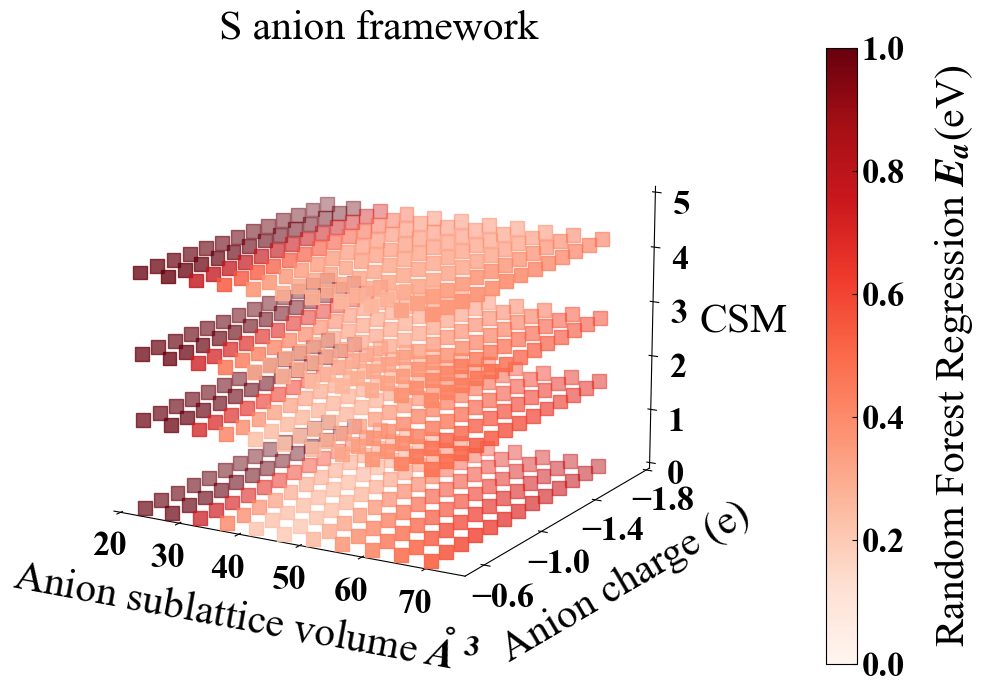

In [104]:
v_lim = {'Cl':[20,40],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[20,75],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[20,60],
          'I':[30,60],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[10,40]}

E_max = {'Cl':1.0,
#                  0.65,0.7,0.75,0.8,0.85],
           'S':2.0,
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':1.0,
          'I':1.0,
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':2.0}
anion_charge_list = {'Cl':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'I':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7]}
charge_coefficient_list1 = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7]
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
size1 = 30
size2 = 20
l_v = [round(k*volume_dict[elements],2) for k in volume_list]  
l_c = anion_charge_list[elements]
fig = plt.figure(figsize=(15,8))
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
# print(X)
# d = distortion_ratio_list
# ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
v = np.array(v_list_3)
c = np.array(c_list_3)
colors = np.array(ress_lists_Ea_forest)
d = np.array(d_list_3)
# print(v)
# np.max(colors)
# cm = plt.cm.get_cmap('RdBu_r')
cm = plt.cm.get_cmap('Reds')
a = ax.scatter(v,c,d,c=colors,cmap=cm,s=100,marker='s',vmin=0,vmax=1.0)
# for i in d[0:-2]:
#     cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)],levels=100, zdir='z', offset=i, cmap='RdBu_r')
# cset = ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
# cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)
# cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)], zdir='y', offset=40, cmap=cm.coolwarm)
cbar = fig.colorbar(a,ax=ax,pad=0.12,fraction=0.036)
plt.title(f'{elements} anion framework',size=size1)
# - E_{i}^{oct}
cbar.set_label('Random Forest Regression $E_a$(eV)',rotation=90,labelpad=size2,size=size1)
cbar.ax.tick_params(labelsize=size1/1.2)
ax.view_init(elev=15,    # 仰角    # 方位角
            azim=-60)
# cbar.ax.set_label('Etet-Eoct')
ax.grid(False)
ax.tick_params(labelsize=size1/1.2)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.patch.set_alpha(0.0)
ax.set_xlabel(f'Anion sublattice volume $\AA^3$',labelpad=size2,size=size1)
ax.set_xlim(v_lim[elements][0], v_lim[elements][-1])
ax.set_ylabel('Anion charge (e)',labelpad=size2,size=size1)
ax.set_ylim(anion_charge_list[elements][0], anion_charge_list[elements][-1])
ax.set_zlabel('CSM', labelpad=size2,size=size1)
# ax.set_yticks(fontproperties = 'Times New Roman', size = 30)
ax.set_zticks(ticks = [0,1,2,3,4,5])
ax.set_yticks(ticks = [-0.6,-1.0,-1.4,-1.8,])
ax.set_xticks(ticks = [20,30,40,50,60,70])
ax.set_zlim(0,5)
plt.margins(0,0,0)
plt.savefig(f'./{elements}_forest_Ea.png',bbox_inches='tight')
plt.show()